In [1]:
import os
import umap
import json
import torch
import itertools
from core import *
import numpy as np
import pandas as pd
import pickle as pkl
from torch import nn
import os.path as op
from tqdm import tqdm
from time import time
from weblogolib import *
from copy import deepcopy
from torch.optim import Adam
from tpot import TPOTRegressor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from capsules.capsules import *
from matplotlib import rcParams
from IPython.display import Image
from matplotlib.lines import Line2D
from torch.autograd import Variable
from matplotlib.patches import Patch
from torch.optim.lr_scheduler import StepLR
from scipy.stats import spearmanr, pearsonr
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, recall_score

In [2]:
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

In [3]:
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.models import ApproximateGP, ExactGP 
from sklearn.metrics import accuracy_score
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel, GridInterpolationKernel
from gpytorch.mlls import VariationalELBO, VariationalELBOEmpirical, DeepApproximateMLL
from gpytorch.distributions import MultivariateNormal
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP

In [4]:
from reproduce_explanations import *

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [5]:
np.random.seed(99)
torch.manual_seed(99)
torch.cuda.manual_seed(99)

In [6]:
rcParams["figure.figsize"] = (12, 8)

In [7]:
w_encoder = GuideHN2d(
    23, capsule_dimension=32, n_routes=1600, n_classes=5, n_channels=2,
).cuda()
w_model = DKL(w_encoder, [1,5*32]).cuda().eval()
w_model.load_state_dict(torch.load("../models/JostEtAl/model59.ptch"))
w_model = w_model.eval()
u = ImperfectMatchTransform("NGG", False, False, fold=False, cut_at_start=0, cut_at_end=0)
transformer = transforms.Compose(
    [
        u, ToTensor(cudap=True)
    ]
)
rownames, colnames, seqnames = init_names(23, "2D-CNN")
m, m_shape = get_m(rownames, colnames, 23, seqnames=seqnames)
random_set = make_random(10000, 23, transformer, "2D-CNN")
random_set = random_set.reshape(-1, np.product(m_shape))
mfa = ModelForALE(w_encoder, w_model, (2, 4, 23))
ale = ALE(mfa.predict, m, ["mean", "variance"])
explanation = ale.explain(random_set)
ale_values = np.stack(explanation.ale_values).squeeze()    

100%|██████████| 40/40 [00:00<00:00, 59.75it/s]


100%|██████████| 40/40 [00:00<00:00, 56.97it/s]


In [8]:
from matplotlib import cm

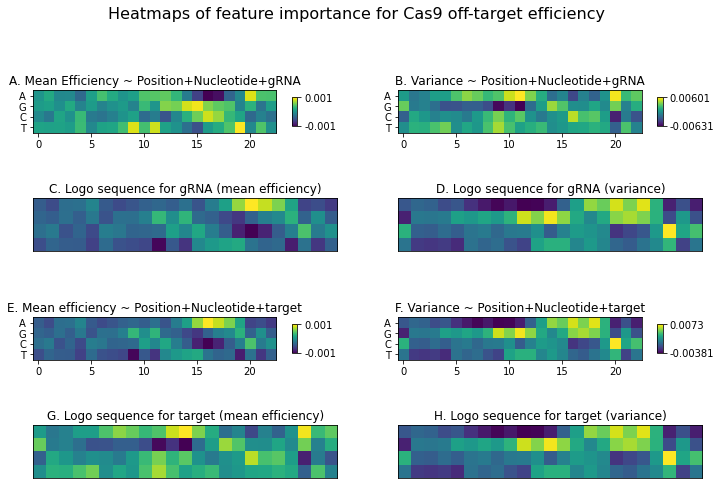

In [9]:
fig,ax = plt.subplots(4,2)
fig.suptitle('Heatmaps of feature importance for Cas9 off-target efficiency', fontsize=16)
ax[0][0].set_title("A. Mean Efficiency ~ Position+Nucleotide+gRNA")
ax[0][0].imshow(ale_values.T[0][1][0:92].reshape(4, 23))
ax[0][0].set_yticks([0,1,2,3])
ax[0][0].set_yticklabels(["A", "G", "C", "T"])
ax[0][1].set_title("B. Variance ~ Position+Nucleotide+gRNA")
ax[0][1].imshow(ale_values.T[1][1][0:92].reshape(4, 23))
ax[0][1].set_yticks([0,1,2,3])
ax[0][1].set_yticklabels(["A", "G", "C", "T"])
cbar1 = fig.colorbar(
    cm.ScalarMappable(), ax=ax[0][0], shrink=0.3,
    ticks=[0, 1], aspect=5
)
cbar1.ax.set_yticklabels(
    [
        str(np.round(np.min(ale_values.T[0][1][0:92]), 3)), 
        str(np.round(np.max(ale_values.T[0][1][0:92]), 3))
    ]
)
cbar2 = fig.colorbar(
    cm.ScalarMappable(), ax=ax[0][1], shrink=0.3,
    ticks=[0, 1], aspect=5
)
cbar2.ax.set_yticklabels(
    [
        str(np.round(np.min(ale_values.T[1][1][0:92]), 5)), 
        str(np.round(np.max(ale_values.T[1][1][0:92]), 5))
    ]
)

ax[1][0].set_title("C. Logo sequence for gRNA (mean efficiency)")
ax[1][0].imshow(ale_values.T[0][1][92:].reshape(4, 23))
ax[1][0].set_yticks([])
ax[1][0].set_xticks([])
ax[1][1].set_title("D. Logo sequence for gRNA (variance)")
ax[1][1].imshow(ale_values.T[1][1][92:].reshape(4, 23))
ax[1][1].set_yticks([])
ax[1][1].set_xticks([])

ax[2][0].set_title("E. Mean efficiency ~ Position+Nucleotide+target")
ax[2][0].imshow(ale_values.T[0][1][92:].reshape(4, 23))
ax[2][0].set_yticks([0,1,2,3])
ax[2][0].set_yticklabels(["A", "G", "C", "T"])
ax[2][1].set_title("F. Variance ~ Position+Nucleotide+target")
ax[2][1].imshow(ale_values.T[1][1][92:].reshape(4, 23))
ax[2][1].set_yticks([0,1,2,3])
ax[2][1].set_yticklabels(["A", "G", "C", "T"])
cbar3 = fig.colorbar(
    cm.ScalarMappable(), ax=ax[2][0], shrink=0.3,
    ticks=[0, 1], aspect=5
)
cbar3.ax.set_yticklabels(
    [
        str(np.round(np.min(ale_values.T[0][1][92:]), 3)), 
        str(np.round(np.max(ale_values.T[0][1][92:]), 3))
    ]
)
cbar4 = fig.colorbar(
    cm.ScalarMappable(), ax=ax[2][1], shrink=0.3,
    ticks=[0, 1], aspect=5
)
cbar4.ax.set_yticklabels(
    [
        str(np.round(np.min(ale_values.T[1][1][92:]), 5)), 
        str(np.round(np.max(ale_values.T[1][1][92:]), 5))
    ]
)

ax[3][0].set_title("G. Logo sequence for target (mean efficiency)")
ax[3][0].imshow(ale_values.T[1][1][0:92].reshape(4, 23))
ax[3][0].set_yticks([])
ax[3][0].set_xticks([])
ax[3][1].set_title("H. Logo sequence for target (variance)")
ax[3][1].imshow(ale_values.T[1][1][92:].reshape(4, 23))
ax[3][1].set_yticks([])
ax[3][1].set_xticks([])

fig.savefig("Figure10_base.png")

In [10]:
make_logo(
    ale_values.T[0][1][0:92].reshape(4, 23), 23, 
    "Figure10C.png", temperature=0.0001, what="mean efficiency"
)
make_logo(
    ale_values.T[1][1][0:92].reshape(4, 23), 23, 
    "Figure10D.png", temperature=0.001, what="mean efficiency"
)
make_logo(
    ale_values.T[0][1][92:].reshape(4, 23), 23, 
    "Figure10G.png", temperature=0.0001, what="mean efficiency"
)
make_logo(
    ale_values.T[1][1][92:].reshape(4, 23), 23, 
    "Figure10H.png", temperature=0.001, what="variance"
)

In [11]:
import cv2

In [12]:
def width_height(base, X1, X2, Y1, Y2):
    extract = base[X1:X2, Y1:Y2, :] 
    height = extract.shape[0]
    width = extract.shape[1]
    return(extract, height, width)

In [13]:
coords = {
    "C": (203, 257, 108, 413),
    "D": (203, 257, 460, 782),
    "H": (430, 490, 460, 782),
    "G": (430, 490, 108, 413),
}

In [14]:
base = cv2.imread("Figure10_base.png")

In [15]:
for a in coords:
    print(a)
    _, height, width = width_height(base, *coords[a])
    logo = cv2.imread("Figure10LETTER.png".replace("LETTER", a))
    base[coords[a][0]:coords[a][1],coords[a][2]:coords[a][3],:] = cv2.resize(logo, (width, height))

C
D
H
G


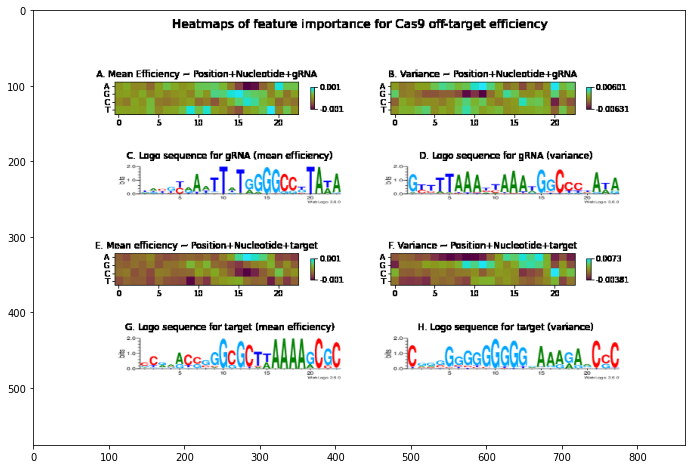

In [16]:
plt.imshow(base)

In [17]:
cv2.imwrite("Figure10.png", base)

True

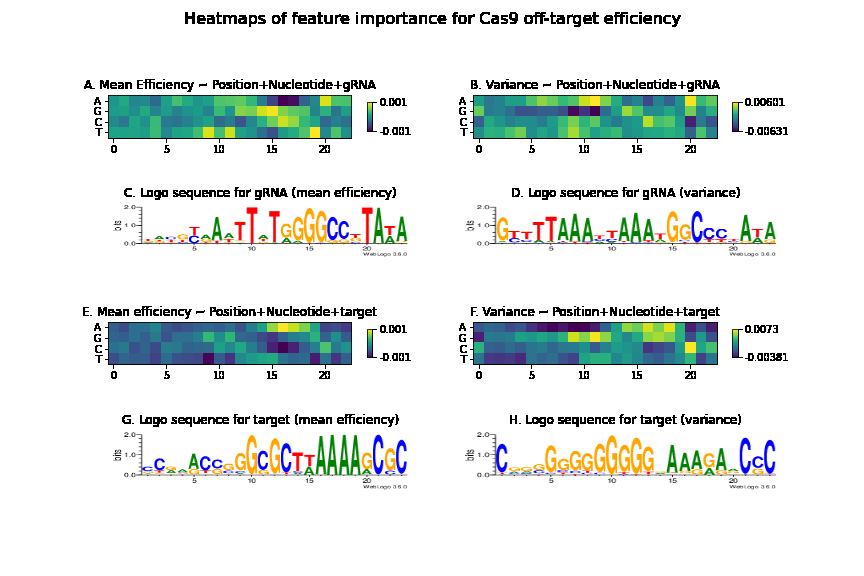

In [18]:
Image("Figure10.png")